In [1]:
# %load_ext autoreload
# %autoreload 2

In [95]:
import os
import pickle
from glob import glob
import logging

import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import cross_val_score, GridSearchCV
from gensim.models import Word2Vec, Doc2Vec
# import tensorflow as tf

from Doc2Vec import Doc2Vec, GensimSVMSklearn
from Constants import SENTIMENTS, TRAINING_DATA, TESTING_DATA

In [3]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

In [4]:
# with open('d2v_gs/d2v_gs_sc_sc_epoch_vs_search.pkl', 'rb') as f:
#     d2v_gs = pickle.load(f)

In [5]:
# pd.DataFrame(d2v_gs.gs.cv_results_).to_csv('d2v_gs/d2v_gs_sc_sc_epoch_vs_search_results.csv')

# Data Load

In [6]:
#####################
# Original review data
#####################
og_base_dir = os.path.join('data', 'reviews')
og_pos_dir = os.path.join(og_base_dir, 'POS')
og_neg_dir = os.path.join(og_base_dir, 'NEG')

og_training_pos_files = glob(os.path.join(og_pos_dir, 'cv[0-8]*.txt'))
og_training_neg_files = glob(os.path.join(og_neg_dir, 'cv[0-8]*.txt'))

og_testing_pos_files = glob(os.path.join(og_pos_dir, 'cv9*.txt'))
og_testing_neg_files = glob(os.path.join(og_neg_dir, 'cv9*.txt'))

og_y_train = np.array([
    *[SENTIMENTS.pos.review_label]*len(og_training_pos_files),
    *[SENTIMENTS.neg.review_label]*len(og_training_neg_files)
])
og_y_test = np.array([
    *[SENTIMENTS.pos.review_label]*len(og_testing_pos_files),
    *[SENTIMENTS.neg.review_label]*len(og_testing_neg_files)
])

# d2v_training_files = [
#     *training_pos_files,
#     *training_neg_files,
#     *testing_pos_files,
#     *testing_neg_files
# ]
# d2v_testing_files = []

# gensim_sklearn = GensimSVMSklearn(
#     d2v_training_files=d2v_training_files,
#     d2v_epochs=100,
#     d2v_infer_epochs=50,
#     d2v_min_count=5,
#     d2v_vector_size=50,
#     d2v_window=5,
#     d2v_dm=0,
#     d2v_dm_concat=0,
#     d2v_dbow_words=1
# )

In [7]:
###########
# IMDB data
###########
imdb_base_dir = 'imdb'
imdb_pos_dir = 'pos'
imdb_neg_dir = 'neg'
imdb_unsup_dir = 'unsup'

imdb_train_dir = os.path.join(imdb_base_dir, 'train')
imdb_train_pos_dir = os.path.join(imdb_train_dir, imdb_pos_dir)
imdb_train_neg_dir = os.path.join(imdb_train_dir, imdb_neg_dir)

imdb_test_dir = os.path.join(imdb_base_dir, 'train')
imdb_test_pos_dir = os.path.join(imdb_test_dir, imdb_pos_dir)
imdb_test_neg_dir = os.path.join(imdb_test_dir, imdb_neg_dir)

imdb_training_pos_files = glob(os.path.join(imdb_train_pos_dir, '*.txt'))
imdb_training_neg_files = glob(os.path.join(imdb_train_neg_dir, '*.txt'))

imdb_testing_pos_files = glob(os.path.join(imdb_test_pos_dir, '*.txt'))
imdb_testing_neg_files = glob(os.path.join(imdb_test_neg_dir, '*.txt'))

imdb_unsup_files = glob(os.path.join(imdb_base_dir, imdb_train_dir, imdb_unsup_dir, '*.txt'))

imdb_y_train = np.array([
    *[SENTIMENTS.pos.review_label]*len(imdb_training_pos_files),
    *[SENTIMENTS.neg.review_label]*len(imdb_training_neg_files)
])
imdb_y_test = np.array([
    *[SENTIMENTS.pos.review_label]*len(imdb_testing_pos_files),
    *[SENTIMENTS.neg.review_label]*len(imdb_testing_neg_files)
])

d2v_training_files = [
    *imdb_training_pos_files,
    *imdb_training_neg_files,
    *imdb_testing_pos_files,
    *imdb_testing_neg_files,
    *imdb_unsup_files
]
d2v_testing_files = []

# Sklearn Pipeline with Gensim

# Load Previous Results

In [10]:
with open('d2v_models/d2v_imdb_1.pkl', 'rb') as f:
    gensim_sklearn = pickle.load(f)

# Sklearn Pipeline with Gensim

In [11]:
# gensim_sklearn = GensimSVMSklearn(
#     d2v_training_files=d2v_training_files,
#     d2v_epochs=100,
#     d2v_infer_epochs=50,
#     d2v_min_count=5,
#     d2v_vector_size=50,
#     d2v_window=5,
#     d2v_dm=0,
#     d2v_dm_concat=0,
#     d2v_dbow_words=1
# )

In [12]:
# gensim_sklearn.train([*og_training_pos_files, *og_training_neg_files], og_y_train)

In [13]:
gensim_sklearn.test([*og_training_pos_files, *og_training_neg_files], og_y_train)

0.9377777777777778


In [14]:
gensim_sklearn.test([*og_testing_pos_files, *og_testing_neg_files], og_y_test)

0.895


## Cross Validation

In [16]:
# gensim_sklearn.cross_validate([*training_pos_files, *training_neg_files], y_train, folds=10)

## Grid Search

In [48]:
# gs_params = {
#     'doc2vec__epochs': (100,),
#     'doc2vec__infer_epochs': (50,),
#     'doc2vec__vector_size': (50,100,200), 
#     'doc2vec__dm': (0,1),
#     'doc2vec__dm_concat': (0,1),
#     'doc2vec__dbow_words': (1,),
#     'doc2vec__window': (5,10,15),
#     'doc2vec__min_count': (5,)
# }
# gensim_sklearn = GensimSVMSklearn(d2v_training_files=d2v_training_files)
# gensim_sklearn.grid_search([*training_pos_files, *training_neg_files], y_train, gs_params)

In [ ]:
# pd.DataFrame(gensim_sklearn.gs.cv_results_).to_json()

In [ ]:
# gensim_sklearn.gs.best_params_

In [ ]:
# gensim_sklearn.gs.best_score_

In [ ]:
# gensim_sklearn.pipeline.named_steps['doc2vec'].model.save('doc2vec_model.gensim')

# Save Results

In [58]:
# with open('d2v_models/d2v_imdb_1.pkl', 'wb') as f:
#     pickle.dump(gensim_sklearn, f)

In [59]:
# gensim_sklearn.pipeline.named_steps['doc2vec'].model.save('d2v_models/d2v_imdb_1.gensim')

## Generate Embeddings

In [10]:
og_training_pos_embeddings = gensim_sklearn.pipeline.named_steps['doc2vec'].transform(og_training_pos_files)
og_training_neg_embeddings = gensim_sklearn.pipeline.named_steps['doc2vec'].transform(og_training_neg_files)
og_testing_pos_embeddings = gensim_sklearn.pipeline.named_steps['doc2vec'].transform(og_testing_pos_files)
og_testing_neg_embeddings = gensim_sklearn.pipeline.named_steps['doc2vec'].transform(og_testing_neg_files)

In [11]:
og_X_train = np.vstack((og_training_pos_embeddings, og_training_neg_embeddings))
og_X_test = np.vstack((og_testing_pos_embeddings, og_testing_neg_embeddings))
og_X_train.shape, og_X_test.shape

((1800, 50), (200, 50))

In [125]:
imdb_training_pos_embeddings = gensim_sklearn.pipeline.named_steps['doc2vec'].transform(imdb_training_pos_files)
imdb_training_neg_embeddings = gensim_sklearn.pipeline.named_steps['doc2vec'].transform(imdb_training_neg_files)
imdb_testing_pos_embeddings = gensim_sklearn.pipeline.named_steps['doc2vec'].transform(imdb_testing_pos_files)
imdb_testing_neg_embeddings = gensim_sklearn.pipeline.named_steps['doc2vec'].transform(imdb_testing_neg_files)

In [126]:
imdb_X_train = np.vstack((imdb_training_pos_embeddings, imdb_training_neg_embeddings))
imdb_X_test = np.vstack((imdb_testing_pos_embeddings, imdb_testing_neg_embeddings))
imdb_X_train.shape, imdb_X_test.shape

((25000, 50), (25000, 50))

# SVC

## OG

In [12]:
logger.info('Training SVM with embeddings')
svm = SVC()
svm.fit(og_X_train, og_y_train)

2021-12-02 17:58:44,551 : INFO : Training SVM with embeddings


SVC()

In [13]:
logger.info('Testing SVM with embeddings')
# svm.cross_validate(og_X_train, og_y_train, folds=10)
og_train_predict = svm.predict(og_X_train)
og_test_predict = svm.predict(og_X_test)

2021-12-02 17:58:47,668 : INFO : Testing SVM with embeddings


In [14]:
svm.score(og_X_train, og_y_train), svm.score(og_X_test, og_y_test)

(0.9366666666666666, 0.9)

In [ ]:
# logger.info('Training SVM with pipeline embeddings')
# svm = SVC()
# svm.train(pipeline_X_train, y_train)

# logger.info('Testing SVM with pipeline embeddings')
# svm.cross_validate(pipeline_X_train, y_train, folds=10)
# svm.test(pipeline_X_train, y_train)
# svm.test(pipeline_X_test, y_test)

In [15]:
cross_val_score(svm, og_X_train, og_y_train, cv=10)

array([0.83888889, 0.85      , 0.86666667, 0.81111111, 0.80555556,
       0.87777778, 0.88888889, 0.83888889, 0.85555556, 0.84444444])

In [16]:
svm_gs_params = {
    "C": np.arange(0.2, 10.2, 0.4),
    "kernel": ["linear", "poly", "rbf", "sigmoid"]
}
grid_search = GridSearchCV(SVC(), svm_gs_params, n_jobs=-1, cv=10)
grid_search.fit(og_X_train, og_y_train)

GridSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
             param_grid={'C': array([0.2, 0.6, 1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ,
       5.4, 5.8, 6.2, 6.6, 7. , 7.4, 7.8, 8.2, 8.6, 9. , 9.4, 9.8]),
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

In [17]:
grid_search.best_score_, grid_search.best_params_

(0.8538888888888889, {'C': 0.6000000000000001, 'kernel': 'rbf'})

In [18]:
svm = SVC(**grid_search.best_params_)
svm.fit(og_X_train, og_y_train)
svm.score(og_X_train, og_y_train), svm.score(og_X_test, og_y_test)

(0.9194444444444444, 0.89)

## IMDB

In [127]:
logger.info('Training SVM with embeddings')
svm = SVC()
svm.fit(imdb_X_train, imdb_y_train)

2021-11-30 20:02:52,121 : INFO : Training SVM with embeddings


SVC()

In [128]:
logger.info('Testing SVM with embeddings')
imdb_train_predict = svm.predict(imdb_X_train)
imdb_test_predict = svm.predict(imdb_X_test)

2021-11-30 20:03:21,619 : INFO : Testing SVM with embeddings


In [129]:
svm.score(imdb_X_train, imdb_y_train), svm.score(imdb_X_test, imdb_y_test)

(0.95008, 0.94992)

In [132]:
cross_val_score(svm, imdb_X_train, imdb_y_train, cv=10)

array([0.8988, 0.922 , 0.914 , 0.9256, 0.9376, 0.9232, 0.9108, 0.9164,
       0.9124, 0.8928])

# Existing Word Embeddings

In [108]:
# wiki_sg = Doc2Vec.load(os.path.join('wiki_sg', 'word2vec.bin'))
# wiki_sg

# Original Methods

In [109]:
# #########
# # Doc2Vec
# #########

# use_d2v_pickle = False
# d2v_pickle_name = 'doc2vec_model.pkl'

# if use_d2v_pickle and os.path.isfile(d2v_pickle_name):
#     logger.info('Loading pickled d2v model')
#     with open(d2v_pickle_name, 'rb') as f:
#         d2v = pickle.load(f)
# else:
#     d2v = Doc2Vec(vector_size=50, epochs=40)

#     logger.info('Loading data')
#     d2v.load_data(training_files=d2v_training_files, testing_files=d2v_testing_files)

#     logger.info('Training doc2vec')
#     d2v.train()

#     with open(d2v_pickle_name, 'wb') as f:
#         pickle.dump(d2v, f)

# # logger.info('Testing doc2vec on the training data')
# # ranks_count, errors = d2v.test()
# # logger.info(ranks_count)

# use_embeddings_pickle = False
# embeddings_pickle_name = 'doc2vec_embeddings.pkl'

# if use_embeddings_pickle and os.path.isfile(embeddings_pickle_name):
#     logger.info('Loading pickled embeddings')
#     with open(embeddings_pickle_name, 'rb') as f:
#         embeddings = pickle.load(f)
# else:
#     logger.info('Obtaining embeddings')
#     embeddings = d2v.generate_embeddings(
#         training_pos_files=training_pos_files,
#         training_neg_files=training_neg_files,
#         testing_pos_files=testing_pos_files,
#         testing_neg_files=testing_neg_files
#     )

#     with open(embeddings_pickle_name, 'wb') as f:
#         pickle.dump(embeddings, f)

In [110]:
# X_train = np.array([
#     *embeddings[TRAINING_DATA][SENTIMENTS.pos.review_label],
#     *embeddings[TRAINING_DATA][SENTIMENTS.neg.review_label]
# ])
# X_test = np.array([
#     *embeddings[TESTING_DATA][SENTIMENTS.pos.review_label],
#     *embeddings[TESTING_DATA][SENTIMENTS.neg.review_label]
# ])

## Lexicon Data

In [ ]:
lexicon_dict = {}
with open('data/sent_lexicon', 'r') as f:
    for line in f:
        word = line.split()[2].split("=")[1]
        polarity = line.split()[5].split("=")[1]
        magnitude = line.split()[0].split("=")[1]
        lexicon_dict[word] = [magnitude, polarity]
lexicon_pos_words = [w for w,t in lexicon_dict.items() if t[1] == 'positive' and t[0] == 'strongsubj' and w in gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv]
lexicon_neg_words = [w for w,t in lexicon_dict.items() if t[1] == 'negative' and t[0] == 'strongsubj' and w in gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv]
# lexicon_pos_words = [w for w,t in lexicon_dict.items() if t[1] == 'positive' and w in gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv]
# lexicon_neg_words = [w for w,t in lexicon_dict.items() if t[1] == 'negative' and w in gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv]

good_words = ['good', *[i[0] for i in gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv.most_similar('good')]]
bad_words = ['bad', *[i[0] for i in gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv.most_similar('bad')]]

wonderful_words = ['wonderful', *[i[0] for i in gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv.most_similar('wonderful')]]
awful_words = ['awful', *[i[0] for i in gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv.most_similar('awful')]]

In [ ]:
# General positive and negative indices
pos_inds = np.where(np.isin(labels,lexicon_pos_words))
neg_inds = np.where(np.isin(labels,lexicon_neg_words))

# Weakly positive and negative words
good_inds = np.where(np.isin(labels, good_words))[0]
bad_inds = np.where(np.isin(labels, bad_words))[0]

# Strongly positive and negative words
wonderful_inds = np.where(np.isin(labels, wonderful_words))[0]
awful_inds = np.where(np.isin(labels, awful_words))[0]

In [ ]:
lexicon_pos_word_embeddings = np.array([gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv[w] for w in lexicon_pos_words])
lexicon_neg_word_embeddings = np.array([gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv[w] for w in lexicon_neg_words])

good_word_embeddings = np.array([gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv[w] for w in good_words])
bad_word_embeddings = np.array([gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv[w] for w in bad_words])

wonderful_word_embeddings = np.array([gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv[w] for w in wonderful_words])
awful_word_embeddings = np.array([gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv[w] for w in awful_words])

# Visualisations

## Gensim Instructions

In [17]:
def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


x_vals, y_vals, labels = reduce_dimensions(gensim_sklearn.pipeline.named_steps['doc2vec'].model)
x_vals = np.array(x_vals)
y_vals = np.array(y_vals)

/Users/alanclark/.pyenv/versions/3.8.11/envs/mlmi13/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/alanclark/.pyenv/versions/3.8.11/envs/mlmi13/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [18]:
def plot_with_plotly(x_vals, y_vals, labels, plot_in_notebook=True):
    from plotly.offline import init_notebook_mode, iplot, plot
    import plotly.graph_objs as go

    trace = go.Scatter(x=x_vals, y=y_vals, mode='text', text=labels)
    data = [trace]

    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename='word-embedding-plot')
    else:
        plot(data, filename='word-embedding-plot.html')


def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    #
    # Label randomly subsampled 25 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

In [19]:
# plot_with_plotly(x_vals, y_vals, labels)

In [20]:
# plot_with_matplotlib(x_vals, y_vals, labels)

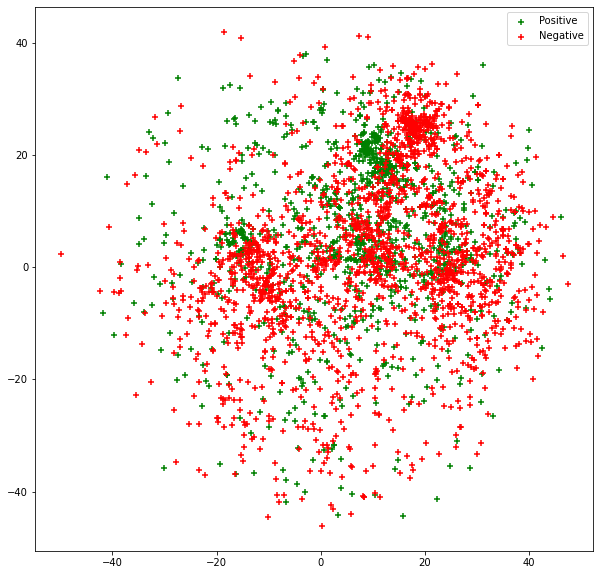

In [57]:
fig, ax = plt.subplots(1, figsize=(10,10))
plt.scatter(x_vals[pos_inds], y_vals[pos_inds], marker='+', c='g', label='Positive')
plt.scatter(x_vals[neg_inds], y_vals[neg_inds], marker='+', c='r', label='Negative')
plt.legend()

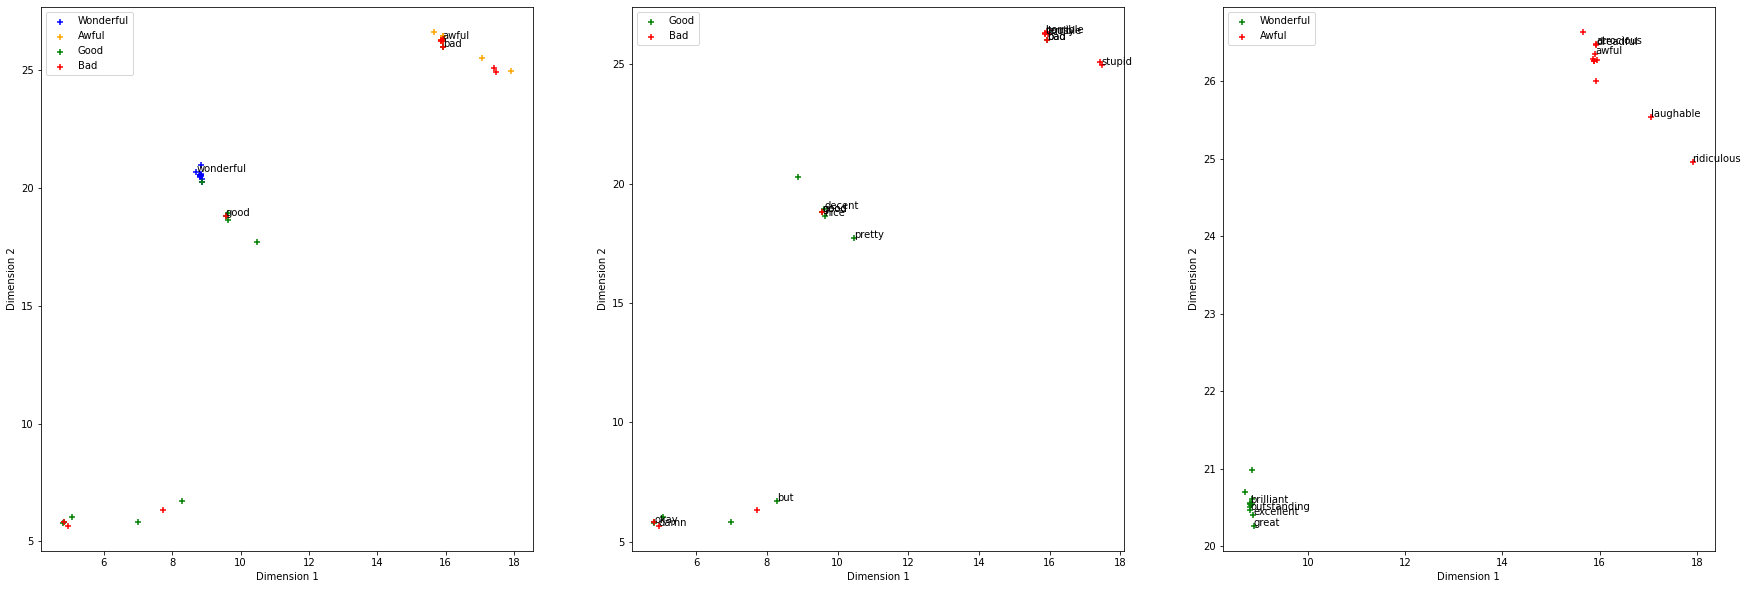

In [58]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))

ax[0].scatter(x_vals[wonderful_inds], y_vals[wonderful_inds], marker='+', c='b', label='Wonderful')
ax[0].scatter(x_vals[awful_inds], y_vals[awful_inds], marker='+', c='orange', label='Awful')
ax[0].scatter(x_vals[good_inds], y_vals[good_inds], marker='+', c='g', label='Good')
ax[0].scatter(x_vals[bad_inds], y_vals[bad_inds], marker='+', c='r', label='Bad')
ax[0].set_xlabel('Dimension 1')
ax[0].set_ylabel('Dimension 2')
ax[0].legend(loc='upper left')
for w in ['wonderful', 'awful', 'good', 'bad']:
    label_ind = np.where(labels == w)[0]
    ax[0].annotate(labels[label_ind][0], (x_vals[label_ind], y_vals[label_ind]))

ax[1].scatter(x_vals[good_inds], y_vals[good_inds], marker='+', c='g', label='Good')
ax[1].scatter(x_vals[bad_inds], y_vals[bad_inds], marker='+', c='r', label='Bad')
for i in good_inds:
    if not i % 2:
        continue
    ax[1].annotate(labels[i], (x_vals[i], y_vals[i]))
for i in bad_inds:
    if not i % 2:
        continue
    ax[1].annotate(labels[i], (x_vals[i], y_vals[i]))
ax[1].set_xlabel('Dimension 1')
ax[1].set_ylabel('Dimension 2')
ax[1].legend(loc='upper left')

ax[2].scatter(x_vals[wonderful_inds], y_vals[wonderful_inds], marker='+', c='g', label='Wonderful')
ax[2].scatter(x_vals[awful_inds], y_vals[awful_inds], marker='+', c='r', label='Awful')
for i in wonderful_inds:
    if i % 2:
        continue
    ax[2].annotate(labels[i], (x_vals[i], y_vals[i]))
for i in awful_inds:
    if i % 2:
        continue
    ax[2].annotate(labels[i], (x_vals[i], y_vals[i]))
ax[2].set_xlabel('Dimension 1')
ax[2].set_ylabel('Dimension 2')
ax[2].legend(loc='upper left')

## Get Word Embeddings

In [36]:
gensim_vectors = np.asarray(gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv.vectors)
gensim_labels = np.asarray(gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv.index_to_key)
gensim_vectors.shape, gensim_labels.shape

((37330, 50), (37330,))

In [37]:
# gensim_word_embeddings = gensim_sklearn.pipeline.named_steps['doc2vec'].model[gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv.key_to_index.keys()]

In [38]:
# gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv.save_word2vec_format('gensim_word_embeddings.gensim')

In [39]:
# !python -m gensim.scripts.word2vec2tensor -i gensim_word_embeddings.gensim -o gensim_word_embeddings.tsv

In [40]:
gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv.most_similar('wonderful')

[('fantastic', 0.8493165969848633),
 ('great', 0.8299423456192017),
 ('fabulous', 0.8122603893280029),
 ('brilliant', 0.8109297752380371),
 ('excellent', 0.80978924036026),
 ('superb', 0.7996698617935181),
 ('marvelous', 0.7967516779899597),
 ('splendid', 0.7888113260269165),
 ('amazing', 0.7810909748077393),
 ('outstanding', 0.7795936465263367)]

## PCA

In [59]:
pca_embeddings = gensim_vectors
# pca_embeddings = np.vstack((lexicon_pos_word_embeddings, lexicon_neg_word_embeddings))

pca_2 = PCA(n_components=2)
pca_embeds_2d = pca_2.fit(pca_embeddings)

pca_3 = PCA(n_components=3)
pca_embeds_3d = pca_3.fit(pca_embeddings)

pca_embeds_2d.explained_variance_ratio_, pca_embeds_3d.explained_variance_ratio_

(array([0.03815994, 0.03271708], dtype=float32),
 array([0.03816257, 0.03271521, 0.03009729], dtype=float32))

### Lexicon Vis

In [60]:
lexicon_pos_words_pca = pca_embeds_2d.transform(lexicon_pos_word_embeddings)
lexicon_neg_words_pca = pca_embeds_2d.transform(lexicon_neg_word_embeddings)

good_words_pca = pca_embeds_2d.transform(good_word_embeddings)
bad_words_pca = pca_embeds_2d.transform(bad_word_embeddings)

wonderful_words_pca = pca_embeds_2d.transform(wonderful_word_embeddings)
awful_words_pca = pca_embeds_2d.transform(awful_word_embeddings)

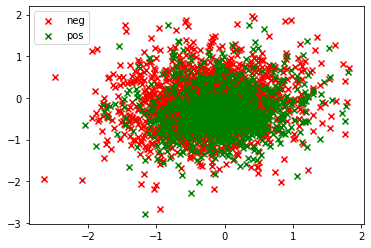

In [155]:
for embed_tuple in [('neg', lexicon_neg_words_pca), ('pos', lexicon_pos_words_pca)]:
    label, embeds = embed_tuple
    plt.scatter(embeds[:,0], embeds[:,1], marker='x', label=label, c='green' if label == 'pos' else 'red')
plt.legend()

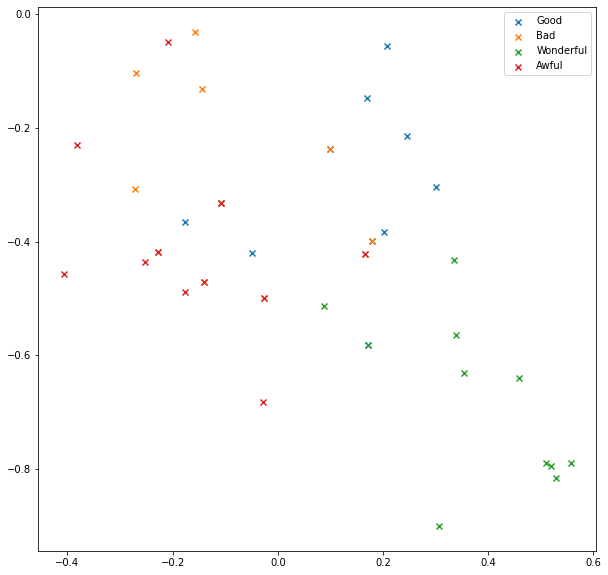

In [64]:
fig, ax = plt.subplots(1, figsize=(10,10))
for embed_tuple in [('Good', good_words_pca), ('Bad', bad_words_pca), ('Wonderful', wonderful_words_pca), ('Awful', awful_words_pca)]:
    label, embeds = embed_tuple
    ax.scatter(embeds[:,0], embeds[:,1], marker='x', label=label)
ax.legend()

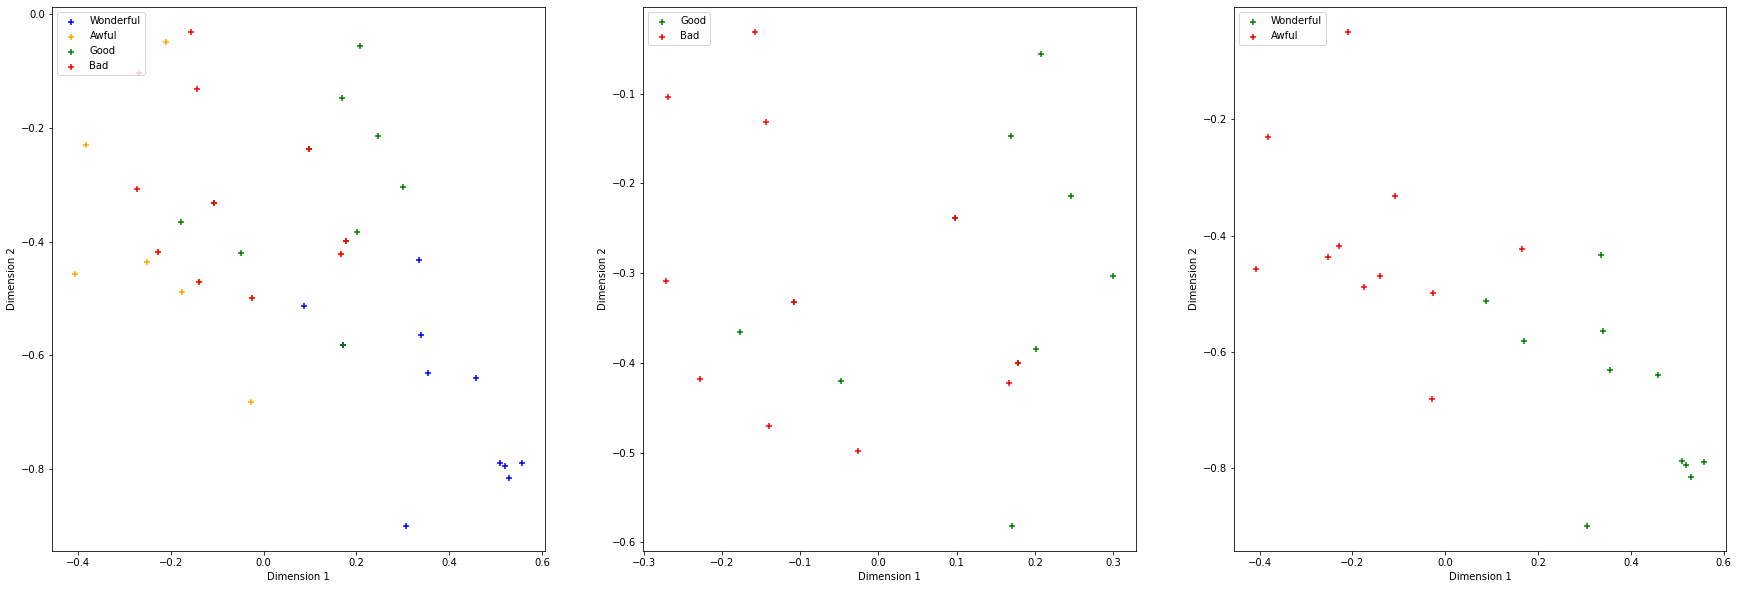

In [152]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))

ax[0].scatter(wonderful_words_pca[:,0], wonderful_words_pca[:,1], marker='+', c='b', label='Wonderful')
ax[0].scatter(awful_words_pca[:,0], awful_words_pca[:,1], marker='+', c='orange', label='Awful')
ax[0].scatter(good_words_pca[:,0], good_words_pca[:,1], marker='+', c='g', label='Good')
ax[0].scatter(bad_words_pca[:,0], bad_words_pca[:,1], marker='+', c='r', label='Bad')
ax[0].set_xlabel('Dimension 1')
ax[0].set_ylabel('Dimension 2')
ax[0].legend(loc='upper left')
for w in ['wonderful', 'awful', 'good', 'bad']:
    label_ind = np.where(labels == w)[0]
    ax[0].annotate(labels[label_ind][0], (x_vals[label_ind], y_vals[label_ind]))

ax[1].scatter(good_words_pca[:,0], good_words_pca[:,1], marker='+', c='g', label='Good')
ax[1].scatter(bad_words_pca[:,0], bad_words_pca[:,1], marker='+', c='r', label='Bad')
for i in good_inds:
    if not i % 2:
        continue
    ax[1].annotate(labels[i], (x_vals[i], y_vals[i]))
for i in bad_inds:
    if not i % 2:
        continue
    ax[1].annotate(labels[i], (x_vals[i], y_vals[i]))
ax[1].set_xlabel('Dimension 1')
ax[1].set_ylabel('Dimension 2')
ax[1].legend(loc='upper left')

ax[2].scatter(wonderful_words_pca[:,0], wonderful_words_pca[:,1], marker='+', c='g', label='Wonderful')
ax[2].scatter(awful_words_pca[:,0], awful_words_pca[:,1], marker='+', c='r', label='Awful')
for i in wonderful_inds:
    if i % 2:
        continue
    ax[2].annotate(labels[i], (x_vals[i], y_vals[i]))
for i in awful_inds:
    if i % 2:
        continue
    ax[2].annotate(labels[i], (x_vals[i], y_vals[i]))
ax[2].set_xlabel('Dimension 1')
ax[2].set_ylabel('Dimension 2')
ax[2].legend(loc='upper left')

2021-12-02 20:31:00,130 : WARNING : No handles with labels found to put in legend.


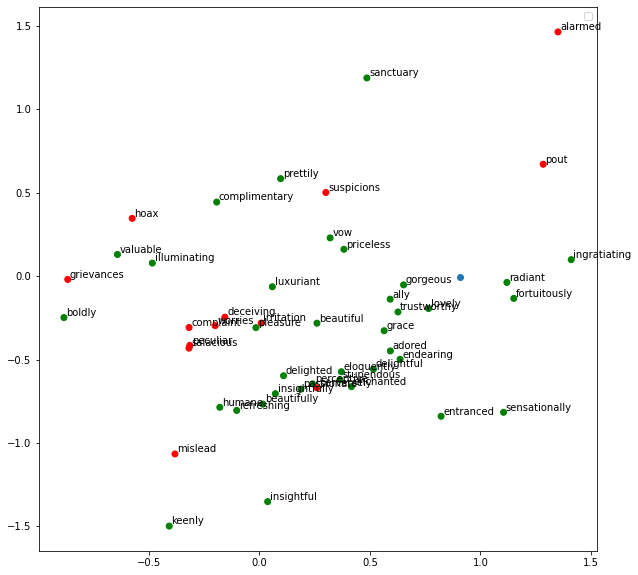

In [153]:
visualisation_review_ind = 10
imdb_review_dir = imdb_train_pos_dir
# imdb_review_dir = imdb_train_neg_dir

review_embedding = gensim_sklearn.pipeline.named_steps['doc2vec'].transform([os.path.join(imdb_review_dir,gensim_sklearn.pipeline.named_steps['doc2vec'].train_corpus[visualisation_review_ind].tags[0])])
review_embedding_pca = pca_embeds_2d.transform(review_embedding)

with open(os.path.join(imdb_review_dir,gensim_sklearn.pipeline.named_steps['doc2vec'].train_corpus[visualisation_review_ind].tags[0])) as f:
    review_tokens = word_tokenize(f.readlines()[0])

review_closest_words = [w[0] for w in gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv.most_similar(review_embedding, topn=1000) if w[0] in [*lexicon_pos_words, *lexicon_neg_words]][:50]
# review_lexicon_tokens = [w for w in review_closest_words if w in [*lexicon_pos_words, *lexicon_neg_words]]
review_lexicon_labels = np.array([lexicon_dict[t][1] for t in review_closest_words])
review_word_embeddings = np.array([gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv[w] for w in review_closest_words])
review_word_embeddings_pca = pca_embeds_2d.transform(review_word_embeddings)

fig, ax = plt.subplots(1, figsize=(10,10))
plt_colors = {'positive':'green', 'negative':'red', 'neutral':'blue', 'both':'yellow'}
ax.scatter(review_embedding_pca[:,0], review_embedding_pca[:,1])
ax.scatter(review_word_embeddings_pca[:,0], review_word_embeddings_pca[:,1], c=[plt_colors[i] for i in review_lexicon_labels])

for i in range(review_word_embeddings_pca.shape[0]):
    ax.annotate(review_closest_words[i], (review_word_embeddings_pca[i,0]+0.01, review_word_embeddings_pca[i,1]+0.01))

ax.legend()

In [148]:
# lexicon_pos_words_pca_3d = pca_embeds_3d.transform(np.array([gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv[w] for w in lexicon_pos_words if w in gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv]))
# lexicon_neg_words_pca_3d = pca_embeds_3d.transform(np.array([gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv[w] for w in lexicon_neg_words if w in gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv]))

# lexicon_pos_words_pca_df = pd.DataFrame(lexicon_pos_words_pca_3d)
# lexicon_pos_words_pca_df['sentiment'] = 'pos'

# lexicon_neg_words_pca_df = pd.DataFrame(lexicon_neg_words_pca_3d)
# lexicon_neg_words_pca_df['sentiment'] = 'neg'

# lexicon_pca_df = pd.concat((lexicon_pos_words_pca_df, lexicon_neg_words_pca_df))
# lexicon_pca_df['size'] = 0.8

# px.scatter_3d(lexicon_pca_df, x=0, y=1, z=2, color='sentiment', size='size')

### Review Visualisation

In [149]:
# visualisation_review_ind = 101
# visualisation_review_words = [w for w in gensim_sklearn.pipeline.named_steps['doc2vec'].train_corpus[visualisation_review_ind].words if w in gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv]
# visualisation_review_word_embeddings = np.array([gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv[w] for w in visualisation_review_words])
# visualisation_review_embedding = gensim_sklearn.pipeline.named_steps['doc2vec'].transform([os.path.join(train_pos_dir,gensim_sklearn.pipeline.named_steps['doc2vec'].train_corpus[visualisation_review_ind].tags[0])])
# visualisation_words = [*visualisation_review_words, 'review']
# visualisation_sentiment = [lexicon_dict.get(w, [None, None])[1] for w in visualisation_review_words]
# visualisation_pos_inds = [i for i,x in enumerate(visualisation_sentiment) if x == 'positive']
# visualisation_neg_inds = [i for i,x in enumerate(visualisation_sentiment) if x == 'negative']
# visualisation_sentiment_inds = [*visualisation_pos_inds, *visualisation_neg_inds]

In [150]:
# visualisation_words_pca = pca_2.transform(visualisation_review_word_embeddings)
# visualisation_review_pca = pca_2.transform(visualisation_review_embedding)

In [151]:
# for lookup_tuple in (('pos', visualisation_pos_inds), ('neg', visualisation_neg_inds)):
#     label, lookup_ind = lookup_tuple
#     plt.scatter(visualisation_words_pca[lookup_ind,0], visualisation_words_pca[lookup_ind,1], marker='x', label=label)
# plt.scatter(visualisation_review_pca[-1,0], visualisation_review_pca[-1,1], marker='x', label='review')
# plt.legend()
# for word_ind in visualisation_sentiment_inds:
#     plt.text(visualisation_words_pca[word_ind,0]+0.02, visualisation_words_pca[word_ind,1]+0.02, visualisation_words[word_ind])

### Pang et al words

In [ ]:
gensim_sklearn = GensimSVMSklearn(
    d2v_training_files=d2v_training_files,
    d2v_epochs=100,
    d2v_infer_epochs=50,
    d2v_min_count=5,
    d2v_vector_size=50,
    d2v_window=5,
    d2v_dm=0,
    d2v_dm_concat=0,
    d2v_dbow_words=1
)

In [ ]:
pang_positive_words = 'love wonderful best great superb still beautiful'.split()
pang_negative_words = 'bad worst stupid waste boring terrible awful'.split()

In [ ]:
pang_positive_word_embeddings = np.array([gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv[w] for w in pang_positive_words])
pang_negative_word_embeddings = np.array([gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv[w] for w in pang_negative_words])
pang_positive_word_embeddings.shape, pang_negative_word_embeddings.shape

In [ ]:
pang_positive_word_pca = pca_2.transform(pang_positive_word_embeddings)
pang_negative_word_pca = pca_2.transform(pang_negative_word_embeddings)

In [ ]:
pos_doc_ind = 10
neg_doc_ind = 10
pos_doc_pca = pca_2.transform(training_pos_embeddings[pos_doc_ind,:][None,:])[0]
neg_doc_pca = pca_2.transform(training_neg_embeddings[neg_doc_ind,:][None,:])[0]

In [ ]:
plt.scatter(pang_positive_word_pca[:,0], pang_positive_word_pca[:,1], marker='x', label='pos')
plt.scatter(pang_negative_word_pca[:,0], pang_negative_word_pca[:,1], marker='x', label='neg')
plt.scatter(pos_doc_pca[0], pos_doc_pca[1], marker='x', label='pos_doc')
plt.scatter(neg_doc_pca[0], neg_doc_pca[1], marker='x', label='neg_doc')
plt.legend()
for word, (x,y) in zip([*pang_positive_words, *pang_negative_words], np.vstack((pang_positive_word_pca, pang_negative_word_pca))):
    plt.text(x+0.05, y+0.05, word)

## TSNE

In [ ]:
logger.info('Training T-SNE model')

tsne = TSNE(n_components=2, verbose=3, n_jobs=-1)
# tsne = TSNE(n_components=2, early_exaggeration=12.0, learning_rate='auto', init='random', verbose=3)

tsne_results = tsne.fit_transform(gensim_word_embeddings)

# Dataframe construction
tsne_df = pd.DataFrame({
    'tsne-one': tsne_results[:,0],
    'tsne-two': tsne_results[:,1],
    # 'tsne-three': tsne_results[:,2],
    'word': tsne_words
})
tsne_df.head()


In [ ]:
tsne_lexicon_df = tsne_df.copy().loc[tsne_df['word'].isin(lexicon_dict)]
tsne_lexicon_df['lexicon'] = tsne_lexicon_df['word'].map(lexicon_dict)
tsne_lexicon_df[['magnitude','sentiment']] = pd.DataFrame(tsne_lexicon_df['lexicon'].tolist(), index=tsne_lexicon_df.index)
tsne_lexicon_df = pd.concat((tsne_lexicon_df, tsne_df.copy().loc[tsne_df['word'] == 'review']))
tsne_lexicon_df.loc[tsne_lexicon_df['word'] == 'review', 'sentiment'] = 'review'

In [ ]:
px.scatter(tsne_lexicon_df , x='tsne-one', y='tsne-two', color='sentiment', hover_name='word')

In [ ]:
tsne_pang_df = tsne_df.copy()[tsne_df['word'].isin([*pang_positive_words, *pang_negative_words])]
tsne_pang_df.loc[tsne_pang_df['word'].isin(pang_positive_words), 'sentiment'] = 'pos'
tsne_pang_df.loc[tsne_pang_df['word'].isin(pang_negative_words), 'sentiment'] = 'neg'
tsne_pang_df

In [ ]:
px.scatter(tsne_pang_df , x='tsne-one', y='tsne-two', color='sentiment', hover_name='word')

In [ ]:
# px.scatter_3d(tsne_df, x='tsne-3d-one', y='tsne-3d-two', z='tsne-3d-three', color='y', size='size')

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-one", y="tsne-two",
    hue="sentiment",
    # palette=sns.color_palette("hls", 10),
    data=tsne_pang_df,
    legend="full",
    alpha=0.3
)

In [ ]:
np.hstack((y_train, y_test))